# Monte Carlo Control

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v1')
env_weighted = gym.make('Blackjack-v1')

In [3]:
"""
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
"""
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [5]:
 """
    returns the best actions for each Q value in the policy
    """
def best_policy(Q):
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [17]:
"""
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
"""
def create_greedy_policy(Q):   
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

"""
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
def create_random_policy(nA): # Policy where all actions are equally likely 
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [8]:
"""
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
""" 
def update_Q_first_visit(episode, Q, alpha, gamma):
    visited = set()  # Keep track of visited state-action pairs
    for t, (state, action, reward) in enumerate(episode):
        if (state, action) not in visited:
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[t:])])
            Q[state][action] = Q[state][action] + alpha*(G - Q[state][action])
            visited.add((state, action))
        else:
            print("first visit")
    return Q

def update_Q_every_visit(episode, Q, alpha, gamma):
    for t, (state, action, reward) in enumerate(episode):
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[t:])])
        Q[state][action] = Q[state][action] + alpha*(G - Q[state][action])
    return Q

In [9]:
def epsilon_greedy(Q, epsilon, nA):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)  # Choose a random action with probability epsilon
    else:
        return np.argmax(Q)  # Choose the action with the highest estimated value according to Q

In [10]:
def play_game_first_visit(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    visited = set()  # Keep track of visited state-action pairs
    
    while True:
        if type(state[0]) == tuple:
            state = state[0]
        action = epsilon_greedy(Q[state], epsilon, nA)
        next_state, reward, terminated, truncated,info = env.step(action)
        if (state, action) not in visited:
            episode.append((state, action, reward))
        else:
            print("first visit")
        visited.add((state, action))  # Mark this state-action pair as visited
        state = next_state
        if terminated:
            break
    
    return episode

def play_game_every_visit(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    
    while True:
        if type(state[0]) == tuple:
            state = state[0]
        action = epsilon_greedy(Q[state], epsilon, nA)
        next_state, reward, terminated, truncated,info  = env.step(action)
        episode.append((state, action, reward))
        
        state = next_state
        if terminated:
            break
    
    return episode


In [11]:
""" 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
def play_game(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        if type(state[0]) == tuple:
            state = state[0]
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()
        next_state, reward, terminated, truncated ,info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated:
            break
    return episode

In [12]:
 """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
def mc_control(env, num_episodes,first_visit=True): 
    epsilon = .8
    eps_min = 0.01
    decay = 0.99
    alpha = 0.001
    gamma = .8
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}. {}".format(i_episode, num_episodes,first_visit), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*decay, eps_min)
        if first_visit:
            episode = play_game_first_visit(env, Q, epsilon, nA)
            Q = update_Q_first_visit(episode, Q, alpha, gamma)
        else:
            episode = play_game_every_visit(env, Q, epsilon, nA)
            Q = update_Q_every_visit(episode, Q, alpha, gamma)
    policy = best_policy(Q)
    return policy, Q

In [13]:
"""
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, trunc, terminated = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            if type(state[0]) == tuple:
                state = state[0]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return target_policy, Q

In [14]:
def launch_method(nb_episodes, first_visit=True):
    policy, Q = mc_control(env, nb_episodes, first_visit)
    V = dict((np.max(v),k) for k, v in Q.items())
    plot_blackjack_values(V)
    plot_policy(policy.T)

/home/theojeannes/Dev/Scolaire/AppParRenforcement/python/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


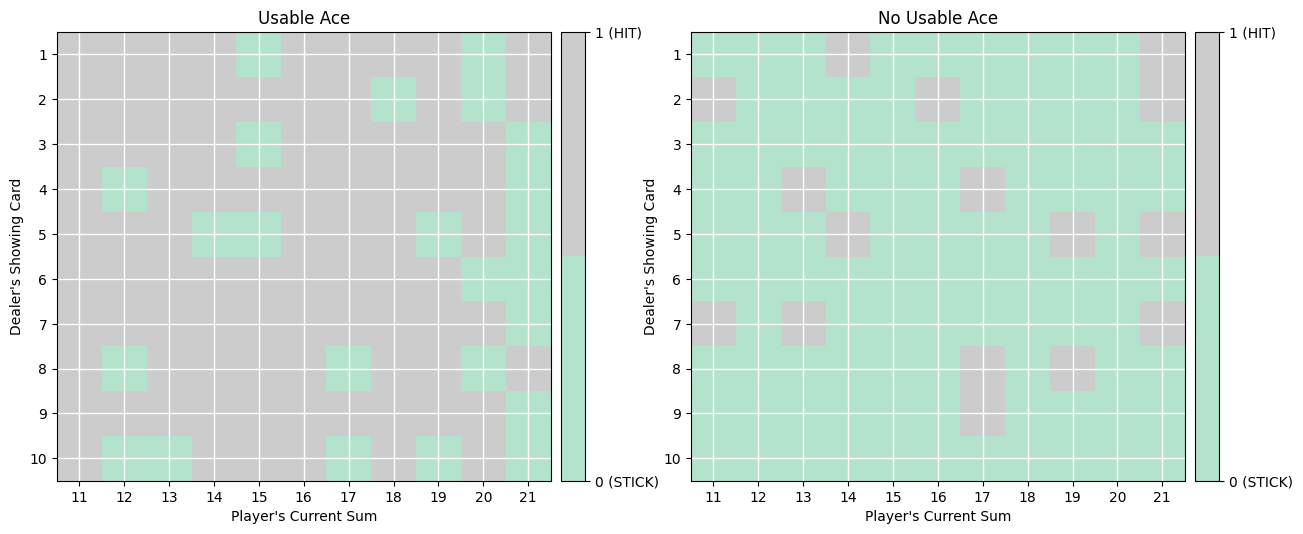

In [15]:
# launch_method(500000)
policy, Q = mc_control(env, 300)
V = dict((k, np.max(v)) for k,v in Q.items()) 
plot_policy(V)

In [86]:
launch_method(500000,False)

/home/theojeannes/Dev/Scolaire/AppParRenforcement/python/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 500000/500000.

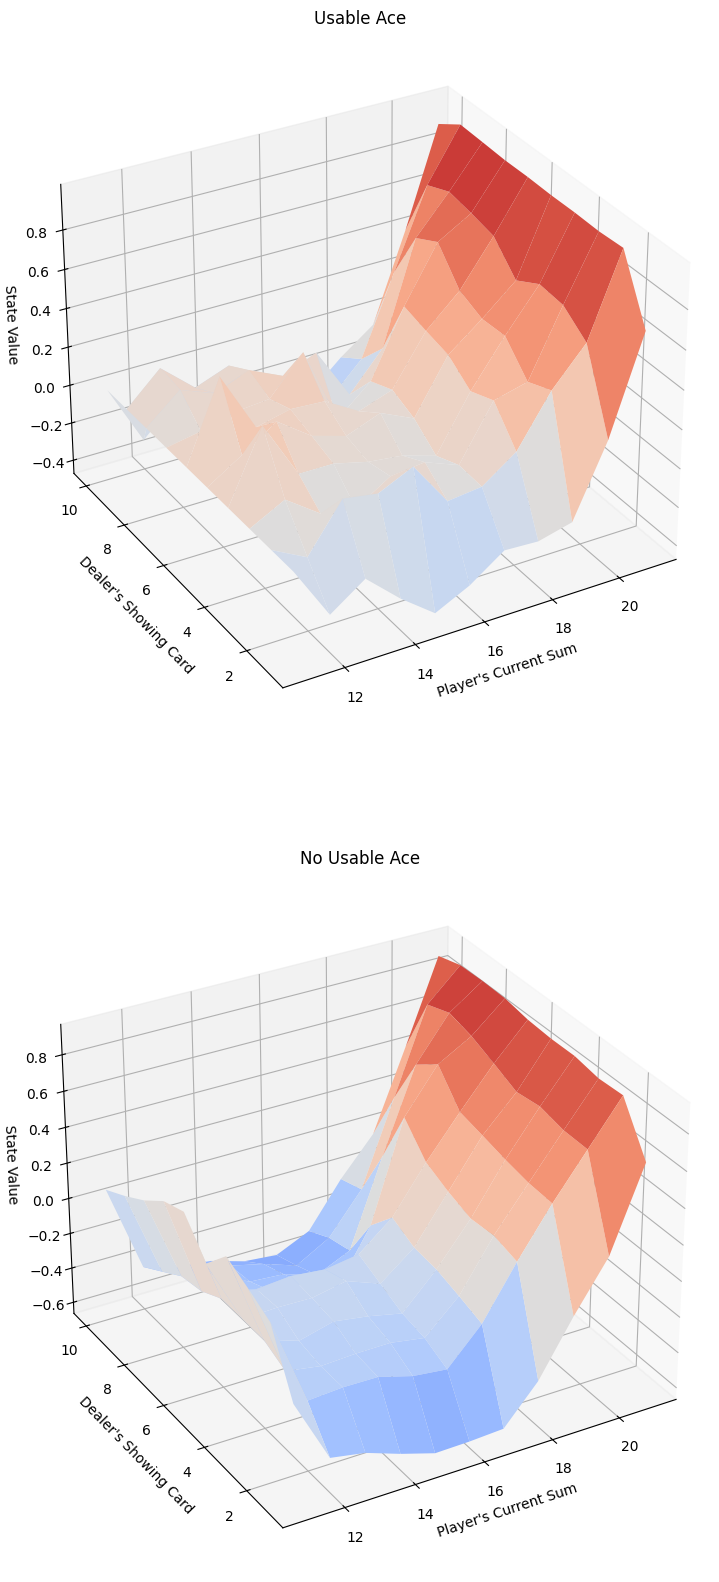

In [18]:
random_policy = create_random_policy(env.action_space.n)
policy_weighted, Q_weighted = mc_control_importance_sampling(env_weighted, 500000, random_policy)
V_weigthed = dict((k,np.max(v)) for k, v in Q_weighted.items())
plot_blackjack_values(V_weigthed)

In [30]:
new_policy = {}
for k,v in policy.items():
    new_policy[(k[1],k[0],k[2])] = v
policy

{(16, 7, False): 0,
 (13, 9, False): 0,
 (16, 9, False): 0,
 (12, 10, False): 1,
 (20, 10, False): 0,
 (13, 10, True): 0,
 (13, 10, False): 1,
 (15, 10, False): 1,
 (16, 10, False): 0,
 (17, 3, False): 0,
 (14, 10, False): 1,
 (17, 6, False): 1,
 (12, 9, False): 1,
 (20, 9, False): 0,
 (18, 1, False): 1,
 (19, 1, False): 0,
 (19, 6, False): 1,
 (19, 9, False): 0,
 (21, 6, True): 0,
 (12, 10, True): 1,
 (11, 6, False): 0,
 (15, 6, False): 1,
 (9, 5, False): 1,
 (13, 3, False): 0,
 (14, 3, False): 1,
 (15, 4, False): 0,
 (12, 7, False): 0,
 (16, 6, False): 0,
 (14, 4, False): 1,
 (15, 3, False): 0,
 (5, 10, False): 1,
 (12, 8, True): 1,
 (17, 1, False): 0,
 (15, 8, False): 0,
 (8, 6, False): 1,
 (15, 2, False): 0,
 (11, 8, False): 1,
 (21, 8, False): 0,
 (16, 8, False): 1,
 (20, 5, False): 0,
 (10, 5, False): 1,
 (13, 1, False): 1,
 (18, 5, False): 0,
 (17, 2, False): 0,
 (12, 2, False): 1,
 (21, 3, False): 0,
 (8, 9, False): 0,
 (18, 9, False): 0,
 (20, 3, False): 1,
 (9, 8, False): 1,


In [31]:
policy_weighted((10,9,False))

array([0., 1.])